In [1]:
import sys
sys.path.insert(1, '/home/elinfi/MasterCode/clustering/class/')

In [2]:
import time
import numpy as np
import seaborn as sns
import cooltools.lib.plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

from time import time
from k_medoids import KMedoids
from cluster_statistics import ClusterStatistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_preparation import DataPreparation
from dissimilarity_matrix import DissimilarityMatrix

In [3]:
# Setting seaborn as default style even if use only matplotlib
sns.set()

# globally set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



In [4]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [5]:
# get path to multi resolution hic data
path_wt = '/home/elinfi/coolers/HiC_wt_001.mcool'
path_cancer = '/home/elinfi/coolers/HiC_cancer_001.mcool'

resolution = 32000
region = 'chr4:5M-7M' # region of genome
balance = True

# create objects of class
wt = DataPreparation(path_wt, resolution, region, balance)
cancer = DataPreparation(path_cancer, resolution, region, balance)

# subtract matrices
diff_mat = cancer.subtract(wt)

In [6]:
# create distance matrix
dissimilarity = DissimilarityMatrix(diff_mat, scaler=None)

# interactions difference
interactions_dist = dissimilarity.scipy_dist(metric='interactions_dist', col1=0, col2=3)

# diagonal distance
diagonal_dist = dissimilarity.scipy_dist(metric='diagonal_dist', col1=0, col2=3)

In [7]:
# calculate weighted distance matrix
w1 = 1
w2 = 0.01

dist_mat = w1*interactions_dist + w2*diagonal_dist

In [8]:
### calculate kmedoids clusters
medoids = 5
random_state = 19

n = dissimilarity.n
triu_nan_idx = dissimilarity.triu_nan_idx

# find clusters using k-medoids
kmedoids = KMedoids(dist_mat)
cluster_result = kmedoids.clusters(medoids=medoids, random_state=random_state)
labels_mat = kmedoids.labels4plotting_nan(n, triu_nan_idx)


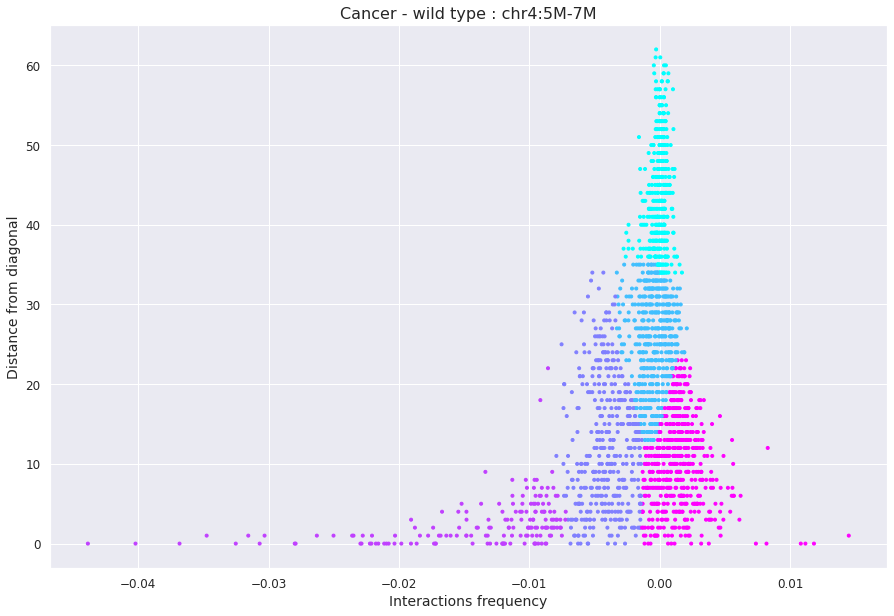

In [9]:
X = dissimilarity.X

f, axs = plt.subplots(figsize=(15, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)

ax = axs

diag = abs(X[:, 0] - X[:, 1])
interactions = X[:, 2]
ax.scatter(interactions, diag, marker='.', c=cluster_result.labels, cmap='cool')
ax.set_title('Cancer - wild type : ' + region)
ax.set_xlabel('Interactions frequency')
ax.set_ylabel('Distance from diagonal')
plt.savefig('../../Figures/diag_vs_IF.png')